In [1]:
import h3
from shapely import wkt
# import urbanity as urb
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

In [39]:
# sg_gdf = gpd.read_file('../shapefile/singapore_4326.geojson')
sg_gdf = gpd.read_file(r'e:\work\spatio_evo_urbanvisenv_svi\范围线\line.shp')
print(sg_gdf.geometry.values[0])
print(sg_gdf.geometry.values[0].__geo_interface__)

MULTILINESTRING ((91.16291941300005 29.68164904400004, 91.16290520000007 29.681649400000026), (90.99105340000006 29.61197210000006, 90.99120080000006 29.611899900000026, 90.99254070000006 29.611236400000053, 90.99530340000007 29.60996780000005, 90.99967000000004 29.60791340000003, 91.00190160000005 29.607192800000064, 91.01058270000004 29.605478600000026, 91.01293070000008 29.605015000000037, 91.02059890000004 29.603485800000044, 91.02119250000004 29.60338370000005, 91.03142740000004 29.601362600000073, 91.03222130000006 29.60126470000006, 91.03264980000006 29.60127730000005, 91.03429710000006 29.601462900000058, 91.03444700000006 29.60149800000005, 91.03442110000003 29.60161990000006, 91.03426750000006 29.60233370000003, 91.03417790000003 29.60302290000004, 91.03403990000004 29.603655100000026, 91.03129860000007 29.617966000000024, 91.03122350000007 29.61880080000003, 91.03133620000006 29.619523600000036, 91.03155080000005 29.62017190000006, 91.03188340000008 29.620834100000025, 91.03

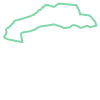

In [3]:
sg_gdf.geometry.values[0]

In [40]:
from shapely.geometry import LineString, MultiLineString, Polygon  
 
polygons = []  
for line in sg_gdf.geometry.values[0].geoms:  
    coords = list(line.coords)   
    if coords[0] != coords[-1]:  
        coords.append(coords[0])  
    polygons.append(Polygon(coords))  
for polygon in polygons:  
    print(polygon)

POLYGON ((91.16291941300005 29.68164904400004, 91.16290520000007 29.681649400000026, 91.16291941300005 29.68164904400004, 91.16291941300005 29.68164904400004))
POLYGON ((90.99105340000006 29.61197210000006, 90.99120080000006 29.611899900000026, 90.99254070000006 29.611236400000053, 90.99530340000007 29.60996780000005, 90.99967000000004 29.60791340000003, 91.00190160000005 29.607192800000064, 91.01058270000004 29.605478600000026, 91.01293070000008 29.605015000000037, 91.02059890000004 29.603485800000044, 91.02119250000004 29.60338370000005, 91.03142740000004 29.601362600000073, 91.03222130000006 29.60126470000006, 91.03264980000006 29.60127730000005, 91.03429710000006 29.601462900000058, 91.03444700000006 29.60149800000005, 91.03442110000003 29.60161990000006, 91.03426750000006 29.60233370000003, 91.03417790000003 29.60302290000004, 91.03403990000004 29.603655100000026, 91.03129860000007 29.617966000000024, 91.03122350000007 29.61880080000003, 91.03133620000006 29.619523600000036, 91.03

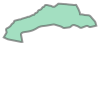

In [7]:
polygons[1]

In [11]:
polygons[1].area

0.008281275539940649

In [42]:

# 通过指定地理范围和六边形分辨率获取六边形ID
sg_gdf.geometry[0] = polygons[1]
hexagon_ids = h3.polyfill(sg_gdf.geometry[0].__geo_interface__, 10, geo_json_conformant = True)

# 自定义函数，将每个六边形ID转换为有效的Shapely多边形

polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

# 将自定义函数应用于六边形ID列表，生成对应的Shapely多边形对象，并存储在GeoSeries中
hexagonal_polygons = gpd.GeoSeries(list(map(polygonise, hexagon_ids)), 
                                      index=hexagon_ids, 
                                      crs="EPSG:4326" 
                                     )

<Axes: >

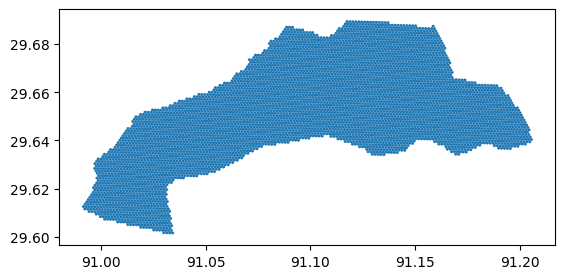

In [43]:
hexagonal_polygons.plot()

In [44]:
hexagonal_polygons.shape

(5944,)

In [45]:
### 1.将六边形几何列表转换为Geopandas的Geodataframe对象。
# 创建一个空的Geopandas的Geodataframe对象，使用EPSG:4326坐标参考系统，并将几何数据设为hexagonal_polygons列表
hex_gdf = gpd.GeoDataFrame(data=None, crs="EPSG:4326", geometry = hexagonal_polygons)
# 重置索引，将六边形多边形id列表移动到一个单独的列中
hex_gdf = hex_gdf.reset_index()
# 重命名列名，以便后续进行空间叠加操作
hex_gdf.columns = ['hexid', 'geometry']

In [46]:
hex_gdf.head()

,hexid,geometry
0,8a3c727442e7fff,"POLYGON ((91.08086 29.66701, 91.08091 29.66767..."
1,8a3c72296d5ffff,"POLYGON ((91.19136 29.64642, 91.19141 29.64709..."
2,8a3c72754d6ffff,"POLYGON ((91.02319 29.62446, 91.02324 29.62513..."
3,8a3c72754c2ffff,"POLYGON ((91.02228 29.62149, 91.02233 29.62215..."
4,8a3c727493affff,"POLYGON ((91.18804 29.65847, 91.18809 29.65914..."


EPSG:32646


<Axes: >

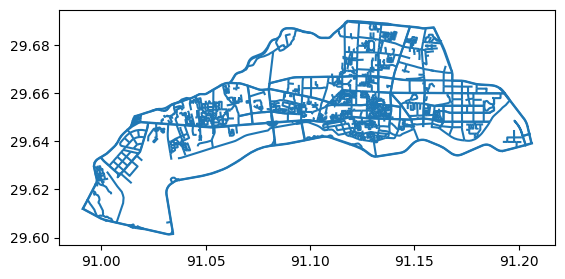

In [47]:
import geopandas as gpd  
  
# 读取shapefile  
gdf_roads = gpd.read_file(r'e:\work\spatio_evo_urbanvisenv_svi\road\road.shp')  
print(gdf_roads.crs)
target_crs = "EPSG:4326"
gdf_roads = gdf_roads.to_crs(target_crs)

gdf_roads.head()
# 访问'geometry'字段  
# roads_geo = gdf_roads['geometry']  
  
# 遍历每一个geometry并打印  
# for geometry in geometries:  
#     print(geometry)
# roads[5]
gdf_roads.plot()  

# gdf = gpd.read_file(shapefile_path)

# 定义目标坐标系为 EPSG:4326

# 将坐标系进行转换

In [55]:
#网络与h3六边形空间相交
hex_intersection = gdf_roads.overlay(hex_gdf, how='intersection')
hex_intersection.head(3)
# hex_intersection.plot()

,u,v,key,osmid,ref,highway,oneway,reversed,length,from_,...,tunnel,bridge,name,lanes,service,maxspeed,junction,access,hexid,geometry
0,31132620,5055844333,0,226057134,None,primary,1,False,8.821,31132620,...,None,None,当热中路,3,None,None,None,None,8a3c7274c0effff,"LINESTRING (91.13988 29.66622, 91.13979 29.66623)"
1,31132620,1485911535,0,408556587,None,secondary,1,False,566.097,31132620,...,None,None,夺底路,2,None,None,None,None,8a3c7274c0effff,"LINESTRING (91.13988 29.66622, 91.13993 29.66643)"
2,31132620,5055844372,0,501532356,None,secondary,1,False,10.044,5055844372,...,None,None,夺底路,2,None,None,None,None,8a3c7274c0effff,"LINESTRING (91.13983 29.66614, 91.13988 29.66622)"


In [49]:
hex_intersection.hexid.value_counts()[[0,1,2,3,4,-5,-4,-3,-2,-1]]


C:\Users\wang.tan.GOA\AppData\Local\Temp\ipykernel_78112\2020097308.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hex_intersection.hexid.value_counts()[[0,1,2,3,4,-5,-4,-3,-2,-1]]


hexid
8a3c7274038ffff    28
8a3c72773d77fff    21
8a3c727402a7fff    19
8a3c727412a7fff    18
8a3c7274386ffff    18
8a3c727465a7fff     1
8a3c7274652ffff     1
8a3c727465b7fff     1
8a3c727732f7fff     1
8a3c7229650ffff     1
Name: count, dtype: int64

In [50]:
hex_intersection.hexid.value_counts()[[0,1,2,3,4,-5,-4,-3,-2,-1]]
# hex_intersection.head()


C:\Users\wang.tan.GOA\AppData\Local\Temp\ipykernel_78112\3541640591.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hex_intersection.hexid.value_counts()[[0,1,2,3,4,-5,-4,-3,-2,-1]]


hexid
8a3c7274038ffff    28
8a3c72773d77fff    21
8a3c727402a7fff    19
8a3c727412a7fff    18
8a3c7274386ffff    18
8a3c727465a7fff     1
8a3c7274652ffff     1
8a3c727465b7fff     1
8a3c727732f7fff     1
8a3c7229650ffff     1
Name: count, dtype: int64

In [18]:
# # 指定感兴趣的列
# column_of_interest = ['Green View Stdev']

# # 创建一个空字典，将绿化视野值映射到osmid
# osmid_to_value = {}
# for osmid in list(singapore_100m_nodes['osmid']):
#     osmid_to_value[osmid] = {}
    
# # # 将绿化视野值添加到对应的osmid键中
# for col in column_of_interest:
#     for oid,value in zip(list(singapore_100m_nodes['osmid']),list(singapore_100m_nodes[col])):
#         osmid_to_value[oid][col] = value

In [19]:
# Simple for loop to visualise the first five rows of our dictionary that maps osmid to Green View value
# for i, k in enumerate(osmid_to_value.items()):
#     if i < 5:
#         print(k)

In [20]:
# 遍历每个列名

# for col in column_of_interest:
#     # 为u列添加绿化视野值
#     hex_intersection[f'u_{col}'] = [osmid_to_value[i][col] for i in hex_intersection['u']]
#     # 为v列添加绿化视野值
#     hex_intersection[f'v_{col}'] = [osmid_to_value[i][col] for i in hex_intersection['v']]

In [21]:
# hex_intersection.head()[['u','v','hexid','u_Green View Stdev','v_Green View Stdev', 'geometry']]


<Axes: >

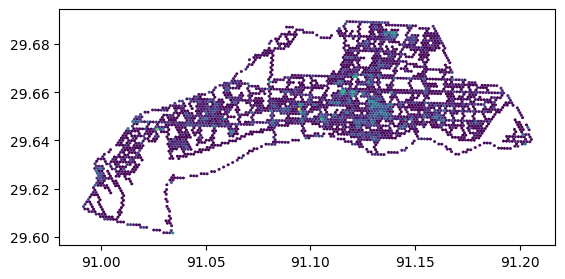

In [63]:
# 通过hexid对起始节点和结束节点属性进行分组，计算边之间的绿化视野GVI相关性
# hex_correlation = hex_intersection.groupby('hexid')[['u_Green View Stdev', 'v_Green View Stdev']].corr(min_periods=30).iloc[0::2,-1]
# hex_correlation = hex_intersection.groupby('hexid')[['length']].corr(min_periods=0.1).iloc[0::2,-1]
# hex_correlation.head()


#  删除多层索引列，并将相关性值实例化为pandas数据帧
# hexagon_df = pd.DataFrame(hex_correlation).reset_index().drop(columns=['level_1'])

# # 重命名数据帧列名
# hexagon_df.columns = ['hexid', 'assortativity']
x = hex_intersection.hexid.value_counts()
# x = pd.DataFrame([x])

x
# # # 最后一步：将相关性信息合并到hex_gdf中 
final_gdf = hex_gdf.merge(x, on = 'hexid')
final_gdf.columns = ['hexid','geometry', 'assortativity']

# # 根据`correlation`列绘制最终数据帧
final_gdf.plot(column='assortativity')

In [58]:
final_gdf.shape

(3002, 3)

In [59]:
target_crs = 'EPSG:3395'
# 转换CRS
final_gdf_01 = final_gdf.to_crs(target_crs)
# 计算转换后的面积
final_gdf_01['area_m2'] = final_gdf_01.area
target_crs = 'EPSG:4326'
# 转换CRS
final_gdf_01 = final_gdf_01.to_crs(target_crs)

# 保存为新的 SHP 文件
output_filepath = r'e:\work\spatio_evo_urbanvisenv_svi\范围线\new_2024_03_25\urban_six_area.shp'
final_gdf_01.to_file(output_filepath)

C:\Users\wang.tan.GOA\AppData\Local\Temp\ipykernel_78112\1647350953.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_gdf_01.to_file(output_filepath)


In [60]:
final_gdf_01.head()

,hexid,geometry,assortativity,area_m2
0,8a3c72772727fff,"POLYGON ((91.01385 29.63066, 91.01389 29.63133...",2,19764.780841
1,8a3c7274b927fff,"POLYGON ((91.16697 29.64801, 91.16702 29.64867...",2,19777.962373
2,8a3c7274962ffff,"POLYGON ((91.18620 29.65253, 91.18625 29.65320...",1,19779.646834
3,8a3c72746c27fff,"POLYGON ((91.05224 29.64873, 91.05229 29.64939...",6,19768.449836
4,8a3c7274c64ffff,"POLYGON ((91.14688 29.66046, 91.14693 29.66112...",1,19776.605813


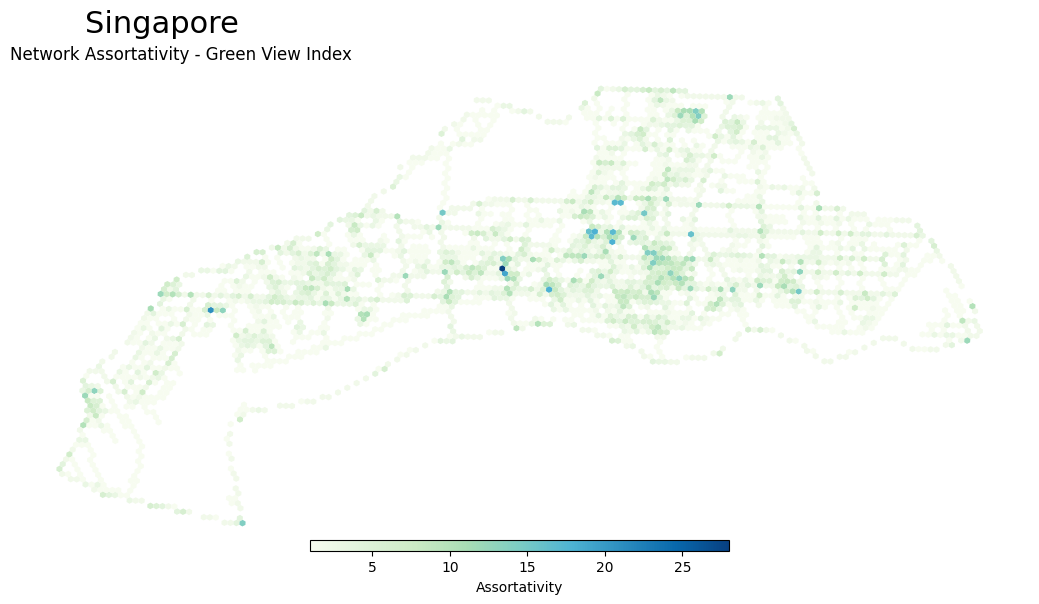

In [61]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(18, 9))

final_gdf_01.plot(column='assortativity', ax=ax, cmap='GnBu', legend=True, 
               legend_kwds={'label': "Assortativity",
                             'orientation': "horizontal",
                             'shrink': 0.30,
                             'anchor':(0.5, 2.2), 
                             'aspect':40, 
                             'ticks':None},
               missing_kwds={"color": "white",
                              "edgecolor": "black",
                              "hatch": "//////",
                              "alpha":0.2,
                              "label": "Missing values",
                              }
                )

ax.set_axis_off()

ax.set_title('Network Assortativity - Green View Index', fontsize=12, loc='left', pad=0)
fig.suptitle('Singapore', fontsize=22, x=0.271, y = 0.94, horizontalalignment='left')

plt.show()